# *In vivo* parameter inference from single-molecule mRNA FISH data.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [2]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

## $\LaTeX$ macros
$\newcommand{kon}{k_{\text{on}}}$
$\newcommand{koff}{k_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$

## Exploring the single-molecule mRNA FISH data from Jones et al. 2014.

In this notebook we will explore the use of the raw data from [Jones et al. 2014](http://science.sciencemag.org/content/346/6216/1533) on single molecule mRNA FISH data to make progress in determining parameters for the model.

First of all let's load the data.

In [66]:
df = pd.read_csv('../../data/mRNA_FISH/Jones_Brewster_2014.csv', index_col=0)
df.head()

,area_cells,date,experiment,spots_totals
0,321,20110920,5DL10,0
1,407,20110920,5DL10,4
2,337,20110920,5DL10,3
3,343,20110920,5DL10,2
4,320,20110920,5DL10,0


Now let's plot the raw data for the *lacUV5* promoter used in the project.

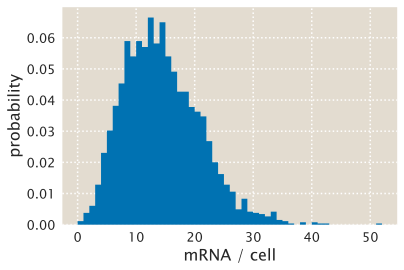

In [98]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=np.arange(0, dfUV5.spots_totals.max()),
             normed=1, histtype='stepfilled')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')

# Two-state unregulated promoter model

Given the lack of agreement between the theory and the data at the protein level we will explore the possibility of using a two-state model for the unregulated promter where it transitions from an empty promoter to occupied by RNAP.

[Peccoud & Ycart](http://www.sciencedirect.com/science/article/pii/S0040580985710271) first derived the mRNA distribution for a two-state promoter from the chemical master equation. This distribution is given by
$$
\small
P(m) = {\Gamma\left( {\kon \over \gm} + m \right) \over
        \Gamma (m + 1) \Gamma\left( {\kon + \koff \over \gm} + m \right)}
        {\Gamma\left( {\kon + \koff \over \gm} \right) \over
         \Gamma\left( {\kon \over \gm} \right) } 
         \left( {\rm \over \gm} \right)^m
         {}_1F_1 \left( {\kon \over \gm} + m, {\koff + \kon \over \gm} + m,
                       {-\rm \over \gm} \right),
$$
where ${}_1F_1$ is the confluent hypergeometric function.

[Sanchez & Kondev](http://linkinghub.elsevier.com/retrieve/pii/S1046202313000959) indicate that in the limit where $\koff \gg \kon$, i.e. an alternative form of the weak promoter approximaiton, and also for $\koff > \gm$ the equation simplifies to a Gamma distribution of the form
$$
P(m) = {\left( {\koff \over \rm} \right)^{\kon \over \gm} \over
        \Gamma \left( {\kon \over \gm} \right)}
        m^{{\kon \over \gm} - 1}
        e^{- \left( {\koff \over \rm} m \right)}.
$$

This convenient form of the distribution has a mean mRNA copy number $\mm$ of the form
$$
\mm = {\kon \over \gm} \cdot {\rm \over \koff}.
$$
The variance takes the form
$$
\sigma_m^2 = {\kon \over \gm} \left( {\rm \over \koff} \right)^2.
$$

Therefore the noise $\eta_m$ satisfies
$$
\eta_m^2 = {\sigma_m^2 \over \mm^2} = {\gm \over \kon}.
$$

### Testing the Gamma distribution with the mRNA data

If we assume the Gamma distribution for the mRNA copy number we can estimate the parameters given the data. [Wikipedia](https://en.wikipedia.org/wiki/Gamma_distribution) says that the two parameters of the distribution are
$$
k \equiv {\kon \over \gm}, \;\; \theta \equiv {\rm \over \koff}.
$$

To infer the parameter values from experimental data the maximum likelihood approach dictates that $\theta$ best parameter estimate $\theta^*$ is given by
$$
\theta^* = {1 \over k N} \sum_{i=1}^N x_i,
$$
where $x_i$ is a data point, and $N$ is the number of data points.

For $k$ there is not a closed form maximum likelihood estimate, but a good initial guess is given by
$$
k \approx {3 - s + \sqrt{(s - 3)^2 + 24 s} \over 12 s},
$$
where
$$
s \equiv \ln \left( {1 \over N} \sum_{i=1}^N x_i \right) - 
         {1 \over N} \sum_{i=1}^N \ln\left( x_i \right).
$$

Wiki claims that this estimate is within 1.5% of the correct value. The website also gives an explicit form for the Newton–Raphson update of this initial guess of the form
$$
k \leftarrow k - {\ln k - \psi(k) - s \over {1 \over k} - \psi '(k)},
$$
where $\psi(k)$ is the [digamma function](https://en.wikipedia.org/wiki/Digamma_function) and $\psi'(k)$ is the [trigamma function](https://en.wikipedia.org/wiki/Trigamma_function).

Let's implement a function to use the Newton-Raphson method to find the best estimate for $k$.

In [131]:
def NR_k_estimate(k, x):
    '''
    Newton-Raphson estimate method for the k parameter of a Gamma distribution
    given x samples of the distribution (data)
    Parameters
    ----------
    k : float.
        Parameter k of the distribution
    x : array-like.
        Data. Experimental samples of the distribution
    Returns
    -------
    Value of Newton-Raphson update step.
    '''
    # Define the length of the data set
    N = len(x)
    # Compute the value of s
    s = np.log(1 / N * np.sum(x)) - 1 / N * np.sum(np.log(x))
    
    return k - (np.log(k) - scipy.special.digamma(k) - s) / \
                            ((1 / k) - scipy.special.polygamma(1, k))

Having define the function let's use the implementation of the Newton-Raphson method from scipy to estimate the best parameter for $k$ and therefore the best estimate for $\theta$.

In [137]:
# Extract the relevant data
x = dfUV5.spots_totals.values
# Add 10^-5 to avoid issues with 0
x = x + 1E-5
N = len(x)
# Define initial guess
s = np.log(1 / N * np.sum(x)) - 1 / N * np.sum(np.log(x))
k0 = (3 - s + np.sqrt((s - 3)**2 + 24 * s)) / (12 * s)

# Define args to be passed to the function
args = (x,)
# Use Newton's method to find the best estimate for k
kopt = scipy.optimize.newton(NR_k_estimate, k0, args=args, maxiter=10000)

# Compute the best estimate for theta
thetaopt = 1 / (kopt * N) * np.sum(x)

print(
'''
Best estimate for k : {0:.1f}
Best estimate for theta : {1:.1f}
'''.format(kopt, thetaopt)
)


/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


RuntimeError: Failed to converge after 10000 iterations, value is nan

Given that this estimate is not converging we can simply use the already implemented `stats.gamma.fit` function to fit the parameters from the distribution.

In [141]:
gamma_shape, gamma_loc, gamma_scale = scipy.stats.gamma.fit(x)

Let's now plot the distribution along with the histogram to compare them side to side.

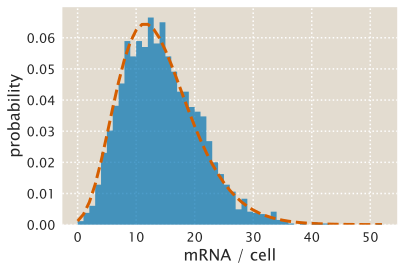

In [142]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())
# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.7)

pdf = scipy.stats.gamma.pdf(x=bins, a=gamma_shape, 
                            loc=gamma_loc, scale=gamma_scale)
plt.plot(bins, pdf, color='r', ls='--', lw=3)

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')

Now we compute the moments of the distribution.

In [147]:
moments = scipy.stats.gamma.stats(a=gamma_shape, 
                            loc=gamma_loc, scale=gamma_scale, moments='mvsk')
m_mean, m_var, m_skew, m_kurt = [float(x) for x in moments]
print(
'''
mean mRNA : {0:.1f}
var mRNA : {1:.1f}
skewness mRNA : {2:.1f}
kurtosis mRNA : {3:.1f}
'''.format(m_mean, m_var, m_skew, m_kurt)
)


mean mRNA : 13.9
var mRNA : 43.1
skewness mRNA : 0.7
kurtosis mRNA : 0.8

